# Regression and Dimensionality Reduction for Financial Time Series Prediction

#### *By Muhammad Taha Raees*
##### *FAST-NUCES*

### Libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import yfinance as yf

### Data Preparation

[*********************100%***********************]  1 of 1 completed


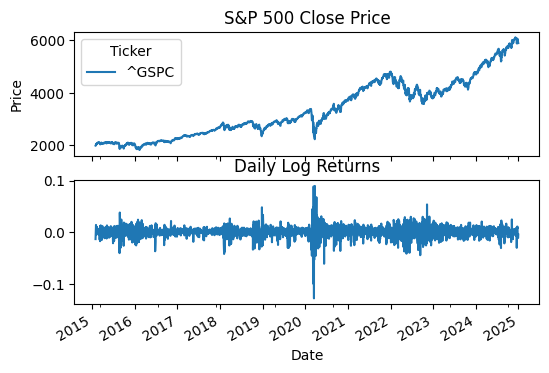

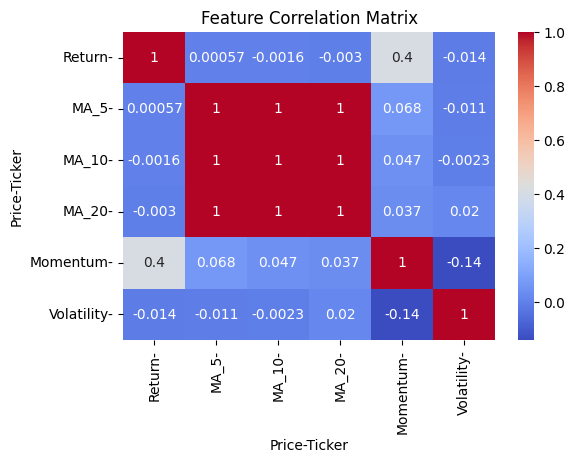

In [52]:
# Download S&P 500 historical data
data = yf.download("^GSPC", start="2015-01-01", end="2025-01-01", auto_adjust=True)
data.head()

# Feature Engineering
data['Return'] = np.log(data['Close'] / data['Close'].shift(1))
data['MA_5'] = data['Close'].rolling(5).mean()
data['MA_10'] = data['Close'].rolling(10).mean()
data['MA_20'] = data['Close'].rolling(20).mean()
data['Momentum'] = data['Close'] - data['Close'].shift(5)
data['Volatility'] = data['Return'].rolling(10).std()

# Drop NaN values
data.dropna(inplace=True)

# Define features (X) and target (y)
X = data[['Return', 'MA_5', 'MA_10', 'MA_20', 'Momentum', 'Volatility']]
y = data['Return'].shift(-1).dropna()
X = X.iloc[:-1, :]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split (80/20)
split = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y[:split], y[split:]


# Visualizations:
#Price and Returns
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
data['Close'].plot(ax=ax[0], title='S&P 500 Close Price')
data['Return'].plot(ax=ax[1], title='Daily Log Returns')
ax[0].set_ylabel('Price')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(X, columns=X.columns).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

### Ordinary Least Squares (OLS)

OLS Train MSE: 0.000138, Test MSE: 0.000070


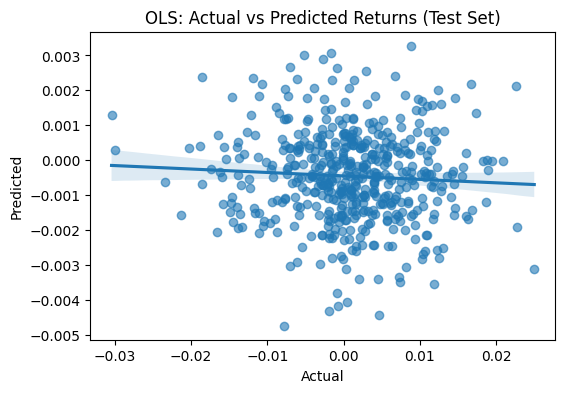

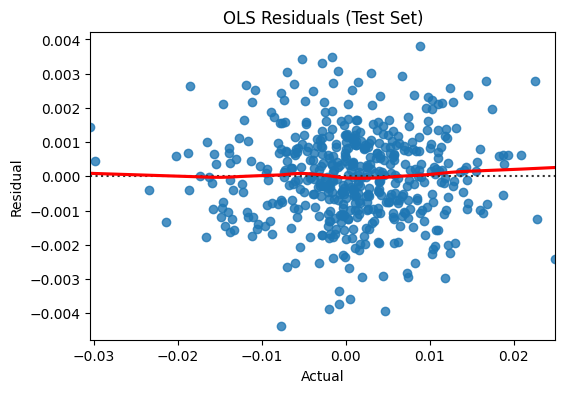

In [53]:
X_train_b = np.c_[np.ones(X_train.shape[0]), X_train]  # add bias term
X_test_b = np.c_[np.ones(X_test.shape[0]), X_test]

beta_hat = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train
y_pred_train = X_train_b @ beta_hat
y_pred_test = X_test_b @ beta_hat

# Evaluate
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"OLS Train MSE: {mse_train:.6f}, Test MSE: {mse_test:.6f}")


# Visualizations

plt.figure(figsize=(6, 4))
sns.regplot(x=y_test, y=y_pred_test, scatter_kws={'alpha': 0.6})
plt.title("OLS: Actual vs Predicted Returns (Test Set)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

plt.figure(figsize=(6, 4))
sns.residplot(x=y_test, y=y_pred_test, lowess=True, line_kws={'color': 'red'})
plt.title("OLS Residuals (Test Set)")
plt.xlabel("Actual")
plt.ylabel("Residual")
plt.show()

### SVD-Based Solution

SVD Test MSE: 0.000070


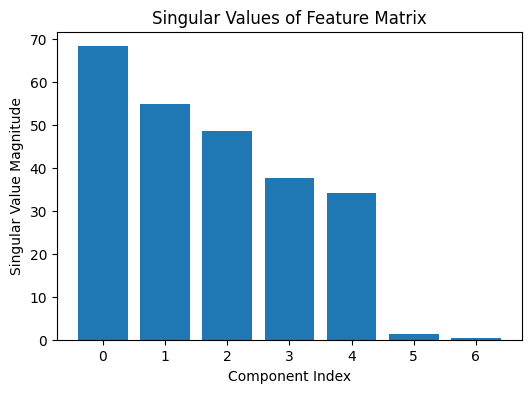

In [54]:
U, S, VT = np.linalg.svd(X_train_b, full_matrices=False)
S_inv = np.diag(1/S)
X_pinv = VT.T @ S_inv @ U.T
beta_svd = X_pinv @ y_train

y_pred_svd = X_test_b @ beta_svd
mse_svd = mean_squared_error(y_test, y_pred_svd)
print(f"SVD Test MSE: {mse_svd:.6f}")

# Visualization
plt.figure(figsize=(6, 4))
plt.bar(range(len(S)), S)
plt.title("Singular Values of Feature Matrix")
plt.xlabel("Component Index")
plt.ylabel("Singular Value Magnitude")
plt.show()

### Gradient Descent

Gradient Descent Test MSE: 0.000070


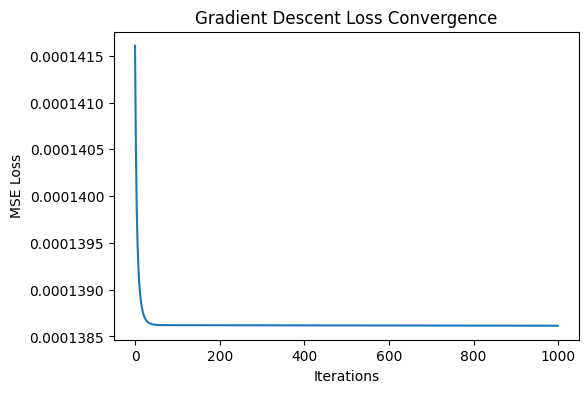

In [55]:
def gradient_descent(X, y, lr=0.01, n_iter=1000):
    m, n = X.shape
    beta = np.zeros(n)
    loss_history = []

    for i in range(n_iter):
        grad = -(2/m) * X.T @ (y - X @ beta)
        beta -= lr * grad
        loss = np.mean((y - X @ beta) ** 2)
        loss_history.append(loss)

    return beta, loss_history

beta_gd, loss_hist = gradient_descent(X_train_b, y_train, lr=0.05, n_iter=1000)
y_pred_gd = X_test_b @ beta_gd
mse_gd = mean_squared_error(y_test, y_pred_gd)
print(f"Gradient Descent Test MSE: {mse_gd:.6f}")

# Plot Loss Convergence
plt.figure(figsize=(6, 4))
plt.plot(loss_hist)
plt.title("Gradient Descent Loss Convergence")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.show()

### PCA & Dimensionality Reduction

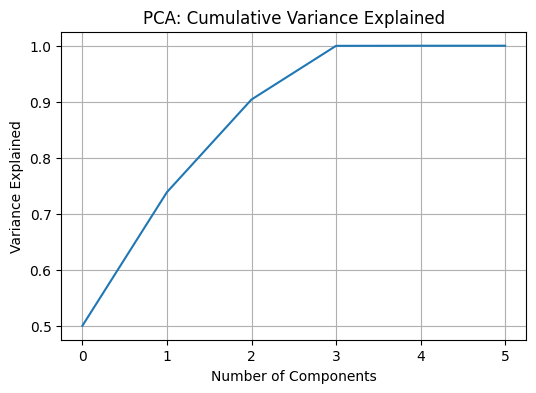

PCA (3 components) Test MSE: 0.000069


In [56]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Scree Plot
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA: Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.show()

# Reduce dimensions (e.g., top 3 PCs)
pca_k = PCA(n_components=3)
X_reduced = pca_k.fit_transform(X_scaled)

# Regression on top 3 PCs
split = int(0.8 * len(X_reduced))
X_train_p, X_test_p = X_reduced[:split], X_reduced[split:]
y_train_p, y_test_p = y[:split], y[split:]

X_train_p_b = np.c_[np.ones(X_train_p.shape[0]), X_train_p]
X_test_p_b = np.c_[np.ones(X_test_p.shape[0]), X_test_p]

beta_pca = np.linalg.inv(X_train_p_b.T @ X_train_p_b) @ X_train_p_b.T @ y_train_p
y_pred_pca = X_test_p_b @ beta_pca
mse_pca = mean_squared_error(y_test_p, y_pred_pca)
print(f"PCA (3 components) Test MSE: {mse_pca:.6f}")

### Ridge Regression

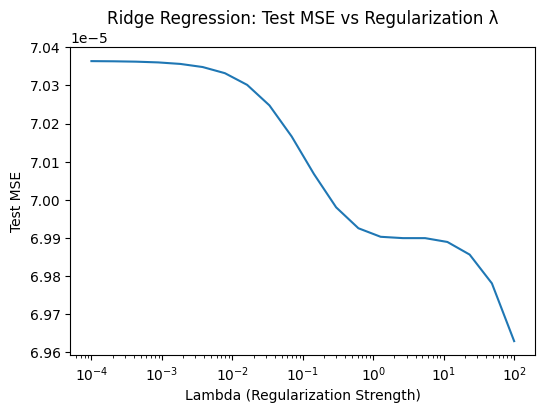

Optimal λ: 100.00000 (Min Test MSE = 0.000070)


In [57]:
lambdas = np.logspace(-4, 2, 20)
mse_ridge = []

for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    mse_ridge.append(mean_squared_error(y_test, y_pred_ridge))

plt.figure(figsize=(6, 4))
plt.semilogx(lambdas, mse_ridge)
plt.title("Ridge Regression: Test MSE vs Regularization λ")
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("Test MSE")
plt.show()

best_lambda = lambdas[np.argmin(mse_ridge)]
print(f"Optimal λ: {best_lambda:.5f} (Min Test MSE = {min(mse_ridge):.6f})")

### Results

In [58]:
results = pd.DataFrame({
    'Method': ['OLS', 'SVD', 'Gradient Descent', 'PCA (3 comp)', 'Ridge (best λ)'],
    'Test MSE': [mse_test, mse_svd, mse_gd, mse_pca, min(mse_ridge)]
})
display(results)

,Method,Test MSE
0,OLS,0.000070
1,SVD,0.000070
2,Gradient Descent,0.000070
3,PCA (3 comp),0.000069
4,Ridge (best λ),0.000070


### Visualizations Summary


1.  **Price and Returns Plot:** Shows the S&P 500 Close Price and Daily Log Returns over time.
2.  **Feature Correlation Matrix:** A heatmap illustrating the correlation between the engineered features.
3.  **OLS: Actual vs Predicted Returns (Test Set):** A scatter plot comparing the actual and predicted returns on the test set using Ordinary Least Squares.
4.  **OLS Residuals (Test Set):** A line plot showing the residuals (difference between actual and predicted values) for the OLS model on the test set.
5.  **Singular Values of Feature Matrix:** A bar plot displaying the singular values obtained from the SVD of the feature matrix.
6.  **PCA: Cumulative Variance Explained:** A plot showing the cumulative explained variance by the principal components in PCA.
7.  **Gradient Descent Loss Convergence:** A plot illustrating how the MSE loss changes over iterations during Gradient Descent.
8.  **Ridge Regression: Test MSE vs Regularization λ:** A plot showing the test Mean Squared Error for different values of the regularization parameter (lambda) in Ridge Regression.